<a href="https://colab.research.google.com/github/bs3537/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/NB8_May_2_2021_Xception_Keras_ILD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORT ALL NECESSARY LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import itertools
import shutil
%matplotlib inline



import tensorflow
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, PReLU, Flatten, MaxPool2D, MaxPooling3D, GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2D, Conv3D, Input, BatchNormalization, Activation, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import regularizers, activations, applications
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Check that we have a GPU instance of Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  2 22:27:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#MOUNT GOOGLE DRIVE AND DEFINE TRAIN AND VALIDATION IMAGE DIRECTORIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Using Keras Image Generator for Automatic train/valid split rather than manual spliting

In [ ]:
images_dir = ('/content/drive/MyDrive/ILD_3 classes_May_2021/TIFF files/')

KERAS FLOW FROM DIRECTORY IMAGE GENERATOR

In [ ]:
BATCH_SIZE    = 32

In [ ]:
traindatagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, validation_split=0.2)

In [ ]:
valdatagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [ ]:
#default for Xception network = 299 x 299

#Train dataset

train_datagen=traindatagen.flow_from_directory(
    images_dir,
    target_size=(299, 299),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="nearest",
    subset = 'training'
)

Found 309 images belonging to 3 classes.


In [ ]:
y_true_labels = train_datagen.classes


In [ ]:
label_map = (train_datagen.class_indices)
label_map

#Prints name of image classes

{'healthy': 0,
 'nonspecific_interstitial_pneumonia': 1,
 'pulmonary_fibrosis': 2}

In [ ]:
valid_datagen=valdatagen.flow_from_directory(
    images_dir,
    target_size=(299, 299),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    interpolation="nearest",
    subset = 'validation'
)

Found 75 images belonging to 3 classes.


PREPARING THE DEEP LEARNING CNN MODEL

In [ ]:
IMAGE_SIZE    = (299, 299)
NUM_CLASSES   = 3 
FREEZE_LAYERS = 1  

In [ ]:
net = Xception(include_top=False,
                 weights=None,
                 input_tensor=None,
                 input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)) 
x = net.output

x = Flatten()(x)
x = Dropout(0.2)(x)

output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False

for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

net_final.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
#TRAIN AND VALIDATE USING THE BUILT CNN MODEL

In [ ]:
#rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', min_delta=0.001, factor=0.1, patience=1)

In [ ]:
NUM_EPOCHS = 100

#stop = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, patience=3, verbose=1)

#save the model in keras model.save format

#filepath="/content/drive/MyDrive/ILD_3 classes_May_2021/May_2_2021_xception.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq='epoch')

hist = net_final.fit(
        train_datagen,
        epochs=NUM_EPOCHS,
        validation_data=valid_datagen,
        verbose=1,
        steps_per_epoch = train_datagen.samples // BATCH_SIZE,
        #callbacks=[stop],
        validation_steps = valid_datagen.samples // BATCH_SIZE)

Epoch 1/100
9/9 [==============================] - 141s 14s/step - loss: 6.8637 - accuracy: 0.4720 - val_loss: 1.0987 - val_accuracy: 0.2812
Epoch 2/100
9/9 [==============================] - 7s 774ms/step - loss: 1.1647 - accuracy: 0.8819 - val_loss: 1.0987 - val_accuracy: 0.2812
Epoch 3/100
9/9 [==============================] - 7s 802ms/step - loss: 0.4147 - accuracy: 0.9190 - val_loss: 1.0986 - val_accuracy: 0.2812
Epoch 4/100
9/9 [==============================] - 7s 801ms/step - loss: 0.1564 - accuracy: 0.9611 - val_loss: 1.0987 - val_accuracy: 0.2812
Epoch 5/100
9/9 [==============================] - 7s 800ms/step - loss: 0.2882 - accuracy: 0.9434 - val_loss: 1.0986 - val_accuracy: 0.2812
Epoch 6/100
9/9 [==============================] - 7s 773ms/step - loss: 0.0342 - accuracy: 0.9909 - val_loss: 1.0987 - val_accuracy: 0.2812
Epoch 7/100
9/9 [==============================] - 7s 772ms/step - loss: 0.0265 - accuracy: 0.9934 - val_loss: 1.0987 - val_accuracy: 0.2812
Epoch 8/100
9

In [ ]:
net_final.save("/content/drive/MyDrive/ILD_3 classes_May_2021/Trained_best_model/)"

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ILD_3 classes_May_2021/Trained_best_model/assets


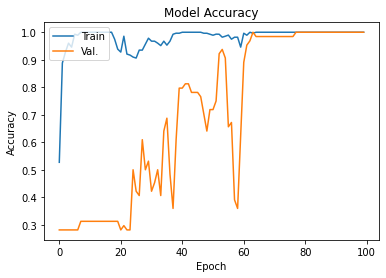

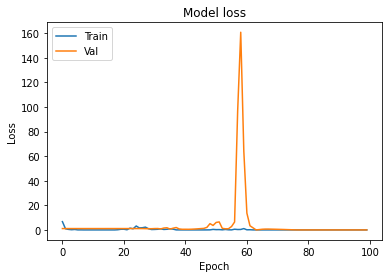

In [ ]:
# Plot training & validation accuracy and loss

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

##Model achieved 100% validation accuracy